In [622]:
import networkx as nx
import pandas as pd
from ast import literal_eval
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

In [623]:
credit = "../Data/tmdb_5000_credits.csv"
movies = "../Data/tmdb_5000_movies.csv"

In [624]:
df_credit = pd.read_csv(credit)
df_movie = pd.read_csv(movies)

# Introduction
We are given two datasets, one containing general informatoin about the movie, the other containing information about the cast. At first i though about splising them together into one file, but seeing as to begin with, im only planning on using the Directors and movie names, we can stick to only using the credit dataset.

In [625]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


## Dtype
The columns title, cast and crew are all read as objects, in reality they are serialized strings, meaning that we need to convert the data into a format we can work with in Python. Using `json_loads()` was my first intention, but this lead to errormessages due to the structure of the data, therefore we make the objects into a python object using `litaral_eval`. I found this tidbit of infromation in a kernel on kaggle.com, more precisely [here](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/notebook).

This method needs more investigating, but it solved our problem for now, so we leave it and that and move on. Below we apply this function onto our target features.


In [626]:
features = ['cast', 'crew']
for feature in features:
    df_credit[feature] = df_credit[feature].apply(literal_eval)

## Our new dataframe
Now, what we want is a dataframe containing the movies, and the directors of those movies. Then we take that director's name, and go through the list of crew again to see if they're mentioned. if they are we add them to a new column "Connected".

In [627]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_coworkers(x):
    coworkers = []
    for v in x:
        coworkers.append(str(v['name']))
    return coworkers

In [628]:
df_credit['director'] = df_credit['crew'].apply(get_director)
df_credit['coworkers'] = df_credit['crew'].apply(get_coworkers)


In [629]:
df_finished = df_credit.drop(['cast', 'crew'], axis=1)

In [630]:
directors  = df_finished.director.to_list()
df_finished.head(10)

,movie_id,title,director,coworkers
0,19995,Avatar,James Cameron,"[Stephen E. Rivkin, Rick Carter, Christopher B..."
1,285,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe..."
2,206647,Spectre,Sam Mendes,"[Thomas Newman, Sam Mendes, Anna Pinnock, John..."
3,49026,The Dark Knight Rises,Christopher Nolan,"[Hans Zimmer, Charles Roven, Christopher Nolan..."
4,49529,John Carter,Andrew Stanton,"[Andrew Stanton, Andrew Stanton, John Lasseter..."
5,559,Spider-Man 3,Sam Raimi,"[Francine Maisler, Joseph M. Caracciolo Jr., S..."
6,38757,Tangled,Byron Howard,"[John Lasseter, Jacob Grimm, Wilhelm Grimm, Jo..."
7,99861,Avengers: Age of Ultron,Joss Whedon,"[Danny Elfman, Christopher Boyes, Christopher ..."
8,767,Harry Potter and the Half-Blood Prince,David Yates,"[Bruno Delbonnel, Stephanie McMillan, Stuart C..."
9,209112,Batman v Superman: Dawn of Justice,Zack Snyder,"[Hans Zimmer, Charles Roven, Christopher Nolan..."


In [631]:
directors

['James Cameron',
 'Gore Verbinski',
 'Sam Mendes',
 'Christopher Nolan',
 'Andrew Stanton',
 'Sam Raimi',
 'Byron Howard',
 'Joss Whedon',
 'David Yates',
 'Zack Snyder',
 'Bryan Singer',
 'Marc Forster',
 'Gore Verbinski',
 'Gore Verbinski',
 'Zack Snyder',
 'Andrew Adamson',
 'Joss Whedon',
 'Rob Marshall',
 'Barry Sonnenfeld',
 'Peter Jackson',
 'Marc Webb',
 'Ridley Scott',
 'Peter Jackson',
 'Chris Weitz',
 'Peter Jackson',
 'James Cameron',
 'Anthony Russo',
 'Peter Berg',
 'Colin Trevorrow',
 'Sam Mendes',
 'Sam Raimi',
 'Shane Black',
 'Tim Burton',
 'Brett Ratner',
 'Dan Scanlon',
 'Michael Bay',
 'Michael Bay',
 'Sam Raimi',
 'Marc Webb',
 'Joseph Kosinski',
 'John Lasseter',
 'Martin Campbell',
 'Lee Unkrich',
 'McG',
 'James Wan',
 'Marc Forster',
 'Bryan Singer',
 'J.J. Abrams',
 'Bryan Singer',
 'Baz Luhrmann',
 'Mike Newell',
 'Guillermo del Toro',
 'Michael Bay',
 'Steven Spielberg',
 'Peter Sohn',
 'Brenda Chapman',
 'Justin Lin',
 'Andrew Stanton',
 'Brett Ratner',
 

Now we have a dataframe consisting of movie_id, title, director, and coworkers. This should be all the data we really need to begin with, so as to give ourselves some general understanding of how to move forward. 

## The Network
Moving forward we want to create a network, where the nodes are the directors, the movies are the edges, and the condition for an edge is as follows: 
If and only if the Director have been working togetether with another director, will there be an edge between the two.

In [632]:
G = nx.Graph()

In [633]:
for director in directors:
    G.add_node(str(director))

In [634]:
G.number_of_nodes()

2350

In [635]:
edges = []
for index, row in df_finished.iterrows():
    director = row['director']
    coworkers = [cw for cw in row['coworkers'] if cw in directors]
    coworkers = list(dict.fromkeys(coworkers))

    for coworker in coworkers:
        edges.append((str(director), str(coworker)))
#edges = list(dict.fromkeys(edges))

In [636]:
print(len(edges))
new_edges = []
for e in edges:
    if e[0] != e[1]:
        new_edges.append(e)
         
new_edges
len(new_edges)

7229


2456

In [637]:
from collections import Counter
c = Counter(new_edges)
dict(c)
c.most_common()

[(('Steven Spielberg', 'Janusz Kamiński'), 15),
 (('Clint Eastwood', 'Robert Lorenz'), 10),
 (('Brett Ratner', 'Mark Helfrich'), 8),
 (('Steven Soderbergh', 'Gregory Jacobs'), 8),
 (('Christopher Nolan', 'Wally Pfister'), 7),
 (('Bryan Singer', 'John Ottman'), 7),
 (('Steven Spielberg', 'Frank Marshall'), 7),
 (('Wes Craven', 'Patrick Lussier'), 7),
 (('Ang Lee', 'James Schamus'), 6),
 (('Dennis Dugan', 'Perry Andelin Blake'), 5),
 (('Bobby Farrelly', 'J.B. Rogers'), 5),
 (('Spike Lee', 'Ernest R. Dickerson'), 5),
 (('Andrew Stanton', 'John Lasseter'), 4),
 (('Chris Weitz', 'Paul Weitz'), 4),
 (('Michael Bay', 'Steven Spielberg'), 4),
 (('Steven Spielberg', 'George Lucas'), 4),
 (('Steven Spielberg', 'David Koepp'), 4),
 (('Steven Spielberg', 'Philip Kaufman'), 4),
 (('Tom Shadyac', 'Steve Oedekerk'), 4),
 (('Ron Howard', 'Akiva Goldsman'), 4),
 (('Joel Schumacher', 'Akiva Goldsman'), 4),
 (('Martin Scorsese', 'Irwin Winkler'), 4),
 (('Robert Zemeckis', 'Steven Spielberg'), 4),
 (('Ada

In [638]:
G.add_edges_from(new_edges)

In [639]:
nx.write_graphml(G, 'nx.graphml')

### Results
The graph is honestly stunning, but it does not really serve our purpose. It is big, and has way too many outliers, therefore we will remove some outlies, and cut our losses.

First of all we need to merge the two datasets, as we need releasedate to be its own column besides name, and coworkers. We simply join the datasets on `id` and take the information we want:

In [640]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [641]:
df_finished = df_finished.rename(columns={'movie_id':'id'})
df_new = df_movie[['id','release_date']]
df_new = df_new.merge(df_finished,on='id')

In [642]:
df_finished

,id,title,director,coworkers
0,19995,Avatar,James Cameron,"[Stephen E. Rivkin, Rick Carter, Christopher B..."
1,285,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe..."
2,206647,Spectre,Sam Mendes,"[Thomas Newman, Sam Mendes, Anna Pinnock, John..."
3,49026,The Dark Knight Rises,Christopher Nolan,"[Hans Zimmer, Charles Roven, Christopher Nolan..."
4,49529,John Carter,Andrew Stanton,"[Andrew Stanton, Andrew Stanton, John Lasseter..."
...,...,...,...,...
4798,9367,El Mariachi,Robert Rodriguez,"[Robert Rodriguez, Robert Rodriguez, Robert Ro..."
4799,72766,Newlyweds,Edward Burns,"[Edward Burns, Edward Burns, Edward Burns, Wil..."
4800,231617,"Signed, Sealed, Delivered",Scott Smith,"[Carla Hetland, Harvey Kahn, Adam Sliwinski, M..."
4801,126186,Shanghai Calling,Daniel Hsia,"[Daniel Hsia, Daniel Hsia]"


To ease our graph making moving forward, we make a quick function that takes our type of dataframe and transforms it into a networkX graph.

In [644]:
def make_graph(dataframe):
    graph = nx.Graph()
    directors  = dataframe.director.to_list()
    for director in directors:
        graph.add_node(str(director))
        
    edges = []
    for index, row in dataframe.iterrows():
        director = row['director']
        coworkers = [cw for cw in row['coworkers'] if cw in directors]
        coworkers = list(dict.fromkeys(coworkers))

        for coworker in coworkers:
            edges.append((str(director), str(coworker)))

    fixed_edges = []
    for e in edges:
        if e[0] != e[1]:
            fixed_edges.append(e)
    edges = fixed_edges

    c = dict(Counter(edges))
    for i in c:
        graph.add_edge(i[0], i[1], weight = c[i])
    return graph

In [645]:
def get_year(x):
        try:
            return int(str(x)[:4])
        except:
            return np.nan 
df_new['year'] = df_new['release_date'].apply(get_year)

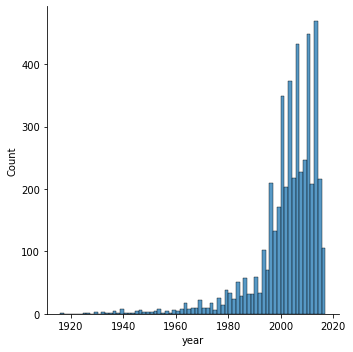

In [646]:
from collections import Counter
import seaborn as sns

data = df_new['year']
#plt.hist(data, bins=np.arange(data.min(), data.max()+1))
sns.displot(data)
plt.show()

## Time to clean
We do not need isladns in our experience, what we are looking for is the main connected graph, when running our experience we will might end up with a few islands aswell, but we will first and foremost remove all islands but the biggest one, due to the fact that the len of it is `2`. 

In [647]:
average = df_new['year'].mean(skipna = True)
print(average)

2002.4687630154103


In [648]:
components = list(nx.connected_components(G))
print([len(c) for c in components if len(c) > 1])

[1117, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 4, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2]


In [649]:
def remove_smaller_islands(graph):
    components = list(nx.connected_components(graph))
    biggest_component_size = max(len(c) for c in components)
    other_components  = [c for c in components if len(c) != biggest_component_size]

    for component in other_components:
        for node in component:
            graph.remove_node(node)
    return graph

In [650]:
G = make_multigraph(df_new)
nx.write_graphml(G, 'nx.graphml')

G = remove_smaller_islands(G)
nx.write_graphml(G, 'nx_trimmed.graphml')

In [651]:
df_before = df_new.drop(df_new[df_new.year <= 2000].index)
df_after = df_new.drop(df_new[df_new.year > 2000].index)


In [652]:
print(len(df_before))
print(len(df_after))
len(df_new)

3329
1475


4803

In [653]:
G1 = make_multigraph(df_before)
G1 = remove_smaller_islands(G1)
nx.write_graphml(G1, 'nx_old.graphml')

In [654]:
G2 = make_multigraph(df_after)
G2 = remove_smaller_islands(G2)
nx.write_graphml(G2, 'nx_new.graphml')

## Tradic enclosue
Now comes the fun part. Lets look for triadic enclosure.

In [655]:
l = []
for item in G1.edges.data():
    l.append(item[2]['weight'])
    #if item[2]['weight'] >= 4:
    #    print(item[2]['weight'])
c = Counter(l)
print(dict(c))

{1: 1047, 3: 25, 2: 84, 7: 1, 4: 6}


### Info
As seen in the code above, very fiew directors have bonds to other directors containing more than one edge, ergo worked together on more than one movie together. I therefore intend to simplyfy my search abit. As it stands, a triadic enclosure says that if one person `A` has a strong bond to person `B` and `C`, person `B` and `C` will form a weak bond with time. As the network we've made is absolutely huge, it might be an idea to make it smaller. Therefore i will do the following. For every Director with a strong bond, i will take every 2 degree neighbors and keep these. 

In [656]:
def trim_network(G_input, weight, number_of_neighbors, data = True):
    graph = G_input.copy()


    # We start by finding all strong edges (strong bond) based on our wished weight
    # We also find the weak edges that we wish to exclude from our calculations.
    strong_edges = [(n1, n2) for n1, n2, w in G_input.edges.data() if w['weight'] >= weight]
    weak_edges = [(n1, n2) for n1, n2, w in G_input.edges.data() if w['weight'] < weight]

    # we then remove the weak edges
    graph.remove_edges_from(weak_edges)
    
    # Then we remove every islands, ergo nodes with no strong edges
    components = list(nx.connected_components(graph))
    single_components  = [c for c in components if len(c) == 1]
    
    for component in single_components:
        for node in component:
            graph.remove_node(node)


    #Furthermore we Grab all neighbors of the nodes with strong edges, and give them an edge in the new graph
    temp_graph = graph.copy()
    for node in graph.nodes():
        neighbors = [n for n in G_input.neighbors(node)]
        neighbor_edges = [(node, n) for n in neighbors]
        for i in neighbor_edges:
            if not graph.has_edge(i[0],i[1]):
                temp_graph.add_edge(i[0], i[1], weight = 1)
    
    graph = temp_graph.copy()
    return graph


In [657]:
G_reduced = trim_network(G1,2,3)
print(len(G_reduced.edges()))

656


In [658]:
G_reduced = remove_smaller_islands(G_reduced)
print(nx.info(G_reduced))
nx.write_graphml(G_reduced, 'nx_reduced.graphml')

Graph with 458 nodes and 650 edges


## Finding the Triadic enclosure
To find Tradic enclosure we simply have to look for instances where one node share a strong bridge to two other nodes, that dont share a direct connection

In [659]:
def find_triadic_enclosures(G_input):
    strong_edges = [(n1, n2) for n1, n2, w in G_input.edges.data() if w['weight'] >= 2]
    nodes = G_input.nodes
    new_edges = []
    for node in nodes:
        l = []
        
        for edge in nx.edges(G_input, [node]):
            l.append(edge[1])

        for v in l: 
            for u in l:
                if not G_input.has_edge(v, u) and u != v:
                    new_edges.append((v,u))
         
    new_edges = list(dict.fromkeys(new_edges))
    return new_edges

In [660]:
def find_stressed_triadic_enclosures(G_input):
    strong_edges = [(n1, n2) for n1, n2, w in G_input.edges.data() if w['weight'] >= 2]
    nodes = G_input.nodes
    new_edges = []
    for node in nodes:
        l = [edge for edge in strong_edges if edge[0] == node or edge[1] == node]
        y = []
        for edge in l:
            if edge[0] != node:
                y.append(edge[0])
            elif edge[1] != node:
                y.append(edge[1])
        if len(y) > 1:
            g_temp = nx.complete_graph(y)
            for edge in g_temp.edges():
                new_edges.append(edge)
                
        #print(l)
    new_edges = list(dict.fromkeys(new_edges))
    return new_edges

These new edges that the function above produces are the edges that could appear with time due to triadic enclosure. These are the edges we want to measure up towards the reality.

In [672]:
G_triadic = G_reduced.copy()
for edge in find_stressed_triadic_enclosures(G_reduced):
    G_triadic.add_edge(edge[0], edge[1], triadic='true', weight=1)

nx.write_graphml(G_triadic, 'nx_triadic.graphml')

In [673]:
l = []
for edge in find_stressed_triadic_enclosures(G_triadic):
    l.append(edge)

print(len(l))

64


In [664]:
G_base_triadic = G.copy()
for edge in find_triadic_enclosures(G):
    G_base_triadic.add_edge(edge[0], edge[1], triadic='true', weight=1)

nx.write_graphml(G_base_triadic, 'nx_base_triadic.graphml')

## The comparison
Now the rest is rather straight forward. We have our graphs `G1` and `G2`, `G1` representing the graph before the year 2000, and `G2` representing the graph after year 2000. Therefore we simply find the edges that came after the year 2000, and compare these to the edges found in the triadic enclosure function. We look for matches between these.

In [665]:
real_edges = [edge for edge in G2.edges]
triadic_edges = find_stressed_triadic_enclosures(G_reduced)

edges_not_in_G2 = [edge for edge in triadic_edges if edge not in real_edges]
real_edges_not_in_triadic = [edge for edge in real_edges if edge not in triadic_edges]
print(len(edges_not_in_G2))

119


In [674]:
edges_guessed_correctly = [edge for edge in real_edges if edge in triadic_edges]
print(len(edges_guessed_correctly))
print(len(real_edges_not_in_triadic))
print(edges_guessed_correctly)

1
413
[('Sydney Pollack', 'Anthony Minghella')]
